# EDA and Feature Engineering + Score Testing

### Loading the cleaned CSVs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import time

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
train=pd.read_csv('datasets/clean_train.csv')
test=pd.read_csv('datasets/clean_test.csv')

In [3]:
train.head()
train=train.drop('Unnamed: 0',axis=1)

In [ ]:
train.shape

In [5]:
test=test.drop('Unnamed: 0',axis=1)

In [6]:
test['SalePrice']=np.zeros(shape=test.iloc[:,0].shape)

In [7]:
test.shape

(879, 190)

In [8]:
df=pd.concat([train,test],sort=False)

# Exploratory Data Analysis

In [9]:
def subplot_scatterplots(dataframe, col1, list_of_col2, list_of_xlabels, list_of_ylabels):
    list_of_col1=list_of_col2
    list_of_col2=[col1 for x in list_of_col2]
    list_of_xlabels=list_of_col2
    list_of_ylabels=list_of_col2
    list_of_xlabels=list_of_col1
    nrows = int(np.ceil(len(list_of_col1)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(13,4*nrows)) # You'll want to specify your figsize
    fig.tight_layout()
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    
    for i, column in enumerate(list_of_col1): # Gives us an index value to get into all our lists
        legend=dataframe.corr()[column][(list_of_col2[i])]
        
        scatter=sns.scatterplot(dataframe[column],dataframe[list_of_col2[i]],ax=ax[i],label='Correlation= ' + str(legend))
        regline=sns.regplot(dataframe[column],dataframe[list_of_col2[i]],ax=ax[i],label='Regression Line') 
        ax[i].set_title('{} vs {}'.format(column,list_of_col2[i]),fontsize=14,pad=20)
        ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_ylabel(list_of_ylabels[i])
        
        plt.legend(['Correlation= '+str(legend)],fontsize='medium',loc='best')

        # feel free to add more settings
        # Set titles, labels, etc here for each subplot


In [10]:
def test_assoc(col1,col2,df,combine=False):

    if col1=='SalePrice':
        return 
    if col2=='SalePrice':
        return 
    assoc=pd.DataFrame()
    assoc['SalePrice']=df['SalePrice'].values
    assoc[col1]=df[col1]
    assoc[col2]=df[col2]
    
    assoc[col1+col2]=df[col1]*df[col2]
    
    corr=assoc.corr().apply(lambda x: abs(x))
    corr1=corr['SalePrice'][col1]
    corr2=corr['SalePrice'][col2]
    corr3=corr['SalePrice'][col1+col2]
    #values
    print('{}:{}\n{}:{}\n{}*{}:{}'.format(col1,corr1,col2,corr2,col1,col2,corr3))
    if combine:
        df[col1+col2]=assoc[col1+col2]
    return assoc[col1+col2]

In [11]:
def larger(col1,col2,df):
    
    df['late_const']=df[col1].where(df[col1]>df[col2],df[col2])

In [12]:
def dropnacols(inp):
    for column in inp.columns:
        if inp[column].isnull().sum() ==len(inp.columns)-1:
            inp=inp.drop(column,axis=1)
            inp=inp.drop(column,axis=0)
    return inp

In [13]:
def drop_col(col1,col2,train,df):

    if col1=='SalePrice':
        return 
    if col2=='SalePrice':
        return 
    assoc=pd.DataFrame()
    assoc['SalePrice']=df['SalePrice'].values
    assoc[col1]=df[col1]
    assoc[col2]=df[col2]
    corr=assoc.corr().apply(lambda x: abs(x))
    #values
    corr1=corr[col1]['SalePrice']
    corr2=corr[col2]['SalePrice']

    if corr1 > corr2:
        return col2
    else:
        return col1


In [14]:
def the_drop(df1,df,tol,drop=True):
    heat=df1.corr()
    s=heat[(abs(heat)>tol)].unstack()
    s=s[(s==s)&(s!=1.0)].sort_values(ascending=False)
    dropper=[]
    for index,x in enumerate(s.index):
        if index%2==0:
            dropper.append(drop_col(x[0],x[1],df1,df))
    print(len(dropper))

    print(df1.shape)
    if drop:
        dropper=[i for i in dropper if i]
        df1.drop(columns=dropper,inplace=True)
        df.drop(columns=dropper,inplace=True)
        print (dropper)
    print(df1.shape)
    print (pd.DataFrame(s))

In [15]:
#splitting into numerical and dummy variables
train_num=train.iloc[:,0:59]
train_dummy=train.iloc[:,58:]

In [16]:
#subplot_scatterplots(train,'SalePrice', list(train_num.columns),'SalePrice',list(train_num.columns))

In [17]:
#subplot_scatterplots(train,'SalePrice', list(train_dummy.columns),'SalePrice',list(train_dummy.columns))

In [18]:
train_num.columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch SF',
       'Screen Porch SF', 'Pool Area', 'Pool QC', 'Fence', 'Misc Val',
       'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [19]:
train_dummy.columns.values

array(['SalePrice', '>4000SF', 'MS Zoning_C (all)', 'MS Zoning_FV',
       'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL',
       'MS Zoning_RM', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave',
       'Lot Shape_IR2', 'Lot Shape_IR3', 'Lot Shape_Reg',
       'Land Contour_HLS', 'Land Contour_Low', 'Land Contour_Lvl',
       'Utilities_NoSeWa', 'Utilities_NoSewr', 'Lot Config_NotCulDSac',
       'Land Slope_Mod', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Greens', 'Neighborhood_GrnHill',
       'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawy

/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Text(0.5, 10.0, 'Correlation between the numeric values of the training dataset')

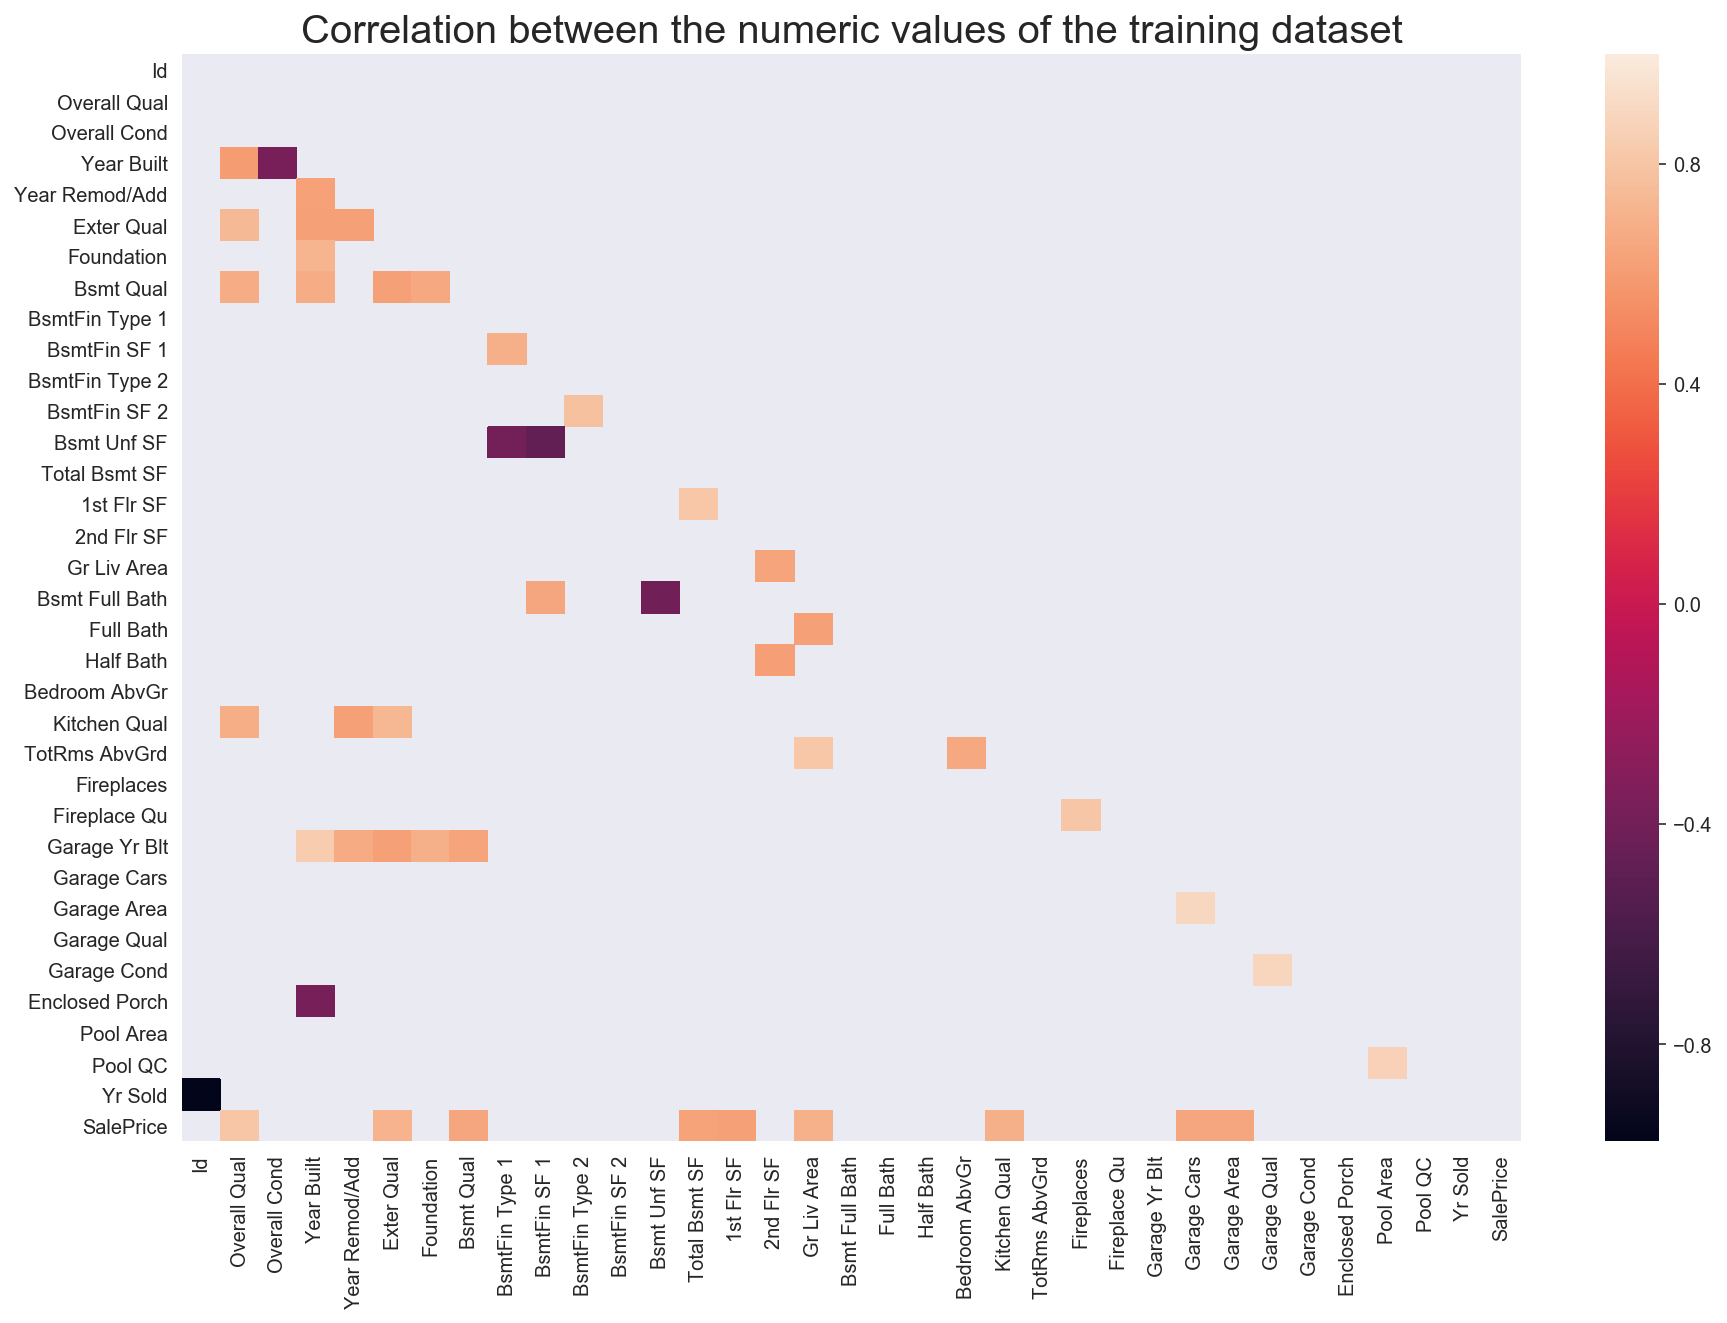

In [20]:
#plot a triangular heatmap of the numerical columns correlations that are above 0.6 or below-0.35
plt.figure(figsize=(15,10))
heat=train_num.corr()#.apply(lambda x: abs(x))
inp=heat[(heat<-0.35)+(heat>0.6)]
inp=dropnacols(inp)
mask = np.zeros_like(inp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(inp,mask=mask)
plt.gca().set_title('Correlation between the numeric values of the training dataset',size=20,y=10.0)



### Drop the collinear variables over 0.85

In [21]:
the_drop(df,test,0.85,drop=True)

10
(2920, 190)
['Exterior 2nd_CmentBd', 'Exterior 1st_VinylSd', 'Exterior 2nd_MetalSd', 'Garage Cars', 'Exterior 2nd_HdBoard', 'Garage Qual', 'Neighborhood_Somerst', 'Exterior 2nd_Wd Sdng', 'Roof Style_Hip', 'Yr Sold']
(2920, 180)
                                                  0
Exterior 2nd_CmentBd Exterior 1st_CemntBd  0.983411
Exterior 1st_CemntBd Exterior 2nd_CmentBd  0.983411
Exterior 1st_VinylSd Exterior 2nd_VinylSd  0.978142
Exterior 2nd_VinylSd Exterior 1st_VinylSd  0.978142
Exterior 2nd_MetalSd Exterior 1st_MetalSd  0.969603
Exterior 1st_MetalSd Exterior 2nd_MetalSd  0.969603
Garage Cars          Garage Area           0.889491
Garage Area          Garage Cars           0.889491
Exterior 2nd_HdBoard Exterior 1st_HdBoard  0.888005
Exterior 1st_HdBoard Exterior 2nd_HdBoard  0.888005
Garage Qual          Garage Cond           0.876399
Garage Cond          Garage Qual           0.876399
Neighborhood_Somerst MS Zoning_FV          0.869688
MS Zoning_FV         Neighborhood_Somerst

In [22]:
the_drop(df,test,0.85,drop=False)

0
(2920, 180)
(2920, 180)
Empty DataFrame
Columns: [0]
Index: []


### Aggregate some columns if the correlation is higher after

In [23]:
bath=train.columns[[('Bath' in x) for x in train.columns]]

In [24]:
def agg(name,listy,df,drop=False):
    aggname=name+'_agg'
    df2=pd.DataFrame(np.zeros(shape=df.iloc[:,0].shape),columns=[aggname])
    for item in listy:
        df2[item]=df[item].values
        df2[aggname]=df2[aggname]+df2[item]
        df2['SalePrice']=df['SalePrice'].values
    print(df2[df2['SalePrice']>0].corr()['SalePrice'].sort_values(ascending=False))
    if drop:
        print (df.shape)
        df.drop(columns=listy,inplace=True)
        df[aggname]=df2[aggname].values
        print (df.shape)
    return df

In [25]:
df=agg('bath',bath,df,drop=True)

SalePrice         1.000000
bath_agg          0.610640
Full Bath         0.537569
Half Bath         0.286387
Bsmt Full Bath    0.282383
Bsmt Half Bath   -0.045062
Name: SalePrice, dtype: float64
(2920, 180)
(2920, 177)


In [26]:
sfs=list([x for x in df.columns if 'SF' in x])

y=['BsmtFin SF 1','Total Bsmt SF','1st Flr SF','Low Qual Fin SF','House Style_SFoyer','>4000SF']
for x in y:
    sfs.remove(x)



In [27]:
df=agg('smallSF',sfs,df,drop=True)

SalePrice          1.000000
smallSF_agg        0.417372
Open Porch SF      0.335435
Wood Deck SF       0.327693
2nd Flr SF         0.250903
Bsmt Unf SF        0.189332
Screen Porch SF    0.135833
3Ssn Porch SF      0.049020
BsmtFin SF 2       0.015022
Name: SalePrice, dtype: float64
(2920, 177)
(2920, 171)


In [28]:
df.columns.values

array(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin SF 1', 'BsmtFin Type 2', 'Total Bsmt SF', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Yr Blt', 'Garage Finish', 'Garage Area', 'Garage Cond',
       'Paved Drive', 'Enclosed Porch', 'Pool Area', 'Pool QC', 'Fence',
       'Misc Val', 'Mo Sold', 'SalePrice', '>4000SF', 'MS Zoning_C (all)',
       'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH',
       'MS Zoning_RL', 'MS Zoning_RM', 'Street_Pave', 'Alley_Grvl',
       'Alley_Pave', 'Lot Shape_IR2', 'Lot Shape_IR3', 'Lot Shape_Reg',
       'Land Contour_HLS', 'Land 

In [29]:
Miscs=list([x for x in df.columns if 'Misc' in x])

y=[]
for x in y:
    sfs.remove(x)

df=agg('misc',Miscs,df,drop=False)

SalePrice            1.000000
Misc Feature_TenC    0.019188
Misc Feature_Elev    0.000697
Misc Val            -0.008478
misc_agg            -0.008492
Misc Feature_Othr   -0.008810
Misc Feature_Gar2   -0.023907
Misc Feature_Shed   -0.047315
Name: SalePrice, dtype: float64


In [30]:
Garage=list([x for x in df.columns if 'Garage' in x])

y=['Garage Area','Garage Type_Out','Garage Cond']
for x in y:
    Garage.remove(x)

Garage

['Garage Yr Blt', 'Garage Finish']

In [31]:
df=agg('Garage',Garage,df,drop=True)

SalePrice        1.000000
Garage_agg       0.561475
Garage Finish    0.558690
Garage Yr Blt    0.552273
Name: SalePrice, dtype: float64
(2920, 171)
(2920, 170)


In [32]:
train=df[df['SalePrice']>0]
test=df[df['SalePrice']==0]

In [33]:
train.to_csv('datasets/train_agged.csv')
test.to_csv('datasets/test_agged.csv')

# Regression Preprocessing(testing of method)

In [34]:
#get the polynomial features
target = 'SalePrice'
nc = [x for x in train.columns if x != target]

X_train,X_test,y_train,y_test=train_test_split(train[nc],train[target])

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test= ss.transform(X_test)
test=test.drop('SalePrice',axis=1)
test_sc=ss.transform(test)
X=ss.transform(train[nc])
y=train[target]



#pf = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
#X_train_poly=pf.fit_transform(X_train)
#X_test_poly=pf.fit_transform(test)
#X_train_poly.shape

In [35]:
X_train.shape

(1530, 169)

In [36]:
y_train.shape

(1530,)

In [37]:
X_test.shape

(511, 169)

In [38]:
y_test.shape

(511,)

In [39]:
#try naive MLR for a baseline performance


In [40]:
lr=LinearRegression()
model=lr.fit(X_train,y_train)
score=model.score(X_test,y_test)



In [41]:
score

-3.063142714666285e+20

In [42]:
cross_val_score(lr,X_train,y_train,cv=10).mean()

-7.1989294877627514e+25

##### We can see from the cross_val_score that variance is very high. We try lasso to see if we can reduce the complexity and thus variance of the predictions

In [43]:
l_alphas = np.logspace(2, 6, 100)
lasso_model = Lasso(alpha=3000,max_iter=10000000)
#lasso_model = LassoCV(alphas=l_alphas, cv=10,max_iter=100000, fit_intercept=True)
lasso_model = lasso_model.fit(X_train, y_train)

In [44]:
len(test.columns[[(item>0)for column,item in zip(test.columns,lasso_model.coef_)]])

26

In [45]:
lasso_model.alpha

3000

In [46]:
#lasso_model = Lasso(alpha=alpha)

In [47]:
cross_val_score(lasso_model,X_train,y_train,cv=15).mean()

0.7951594141623255

In [48]:
cross_val_score(lasso_model,X_train,y_train,cv=10)

array([0.89946969, 0.89341898, 0.86319769, 0.87386153, 0.88772015,
       0.03590909, 0.89236876, 0.91398695, 0.87457905, 0.87750606])

In [49]:
lasso_model = lasso_model.fit(X_train,y_train)

In [50]:
train_predictions=lasso_model.predict(X_train)

In [51]:
test_predictions=lasso_model.predict(X_test)

0.8911330225371463

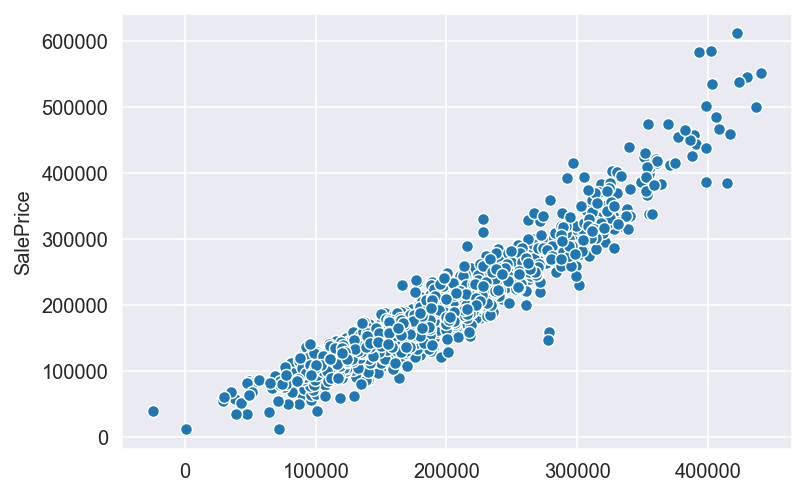

In [52]:
sns.scatterplot(train_predictions,y_train)
lasso_model.score(X_train,y_train)

0.8793391641376365

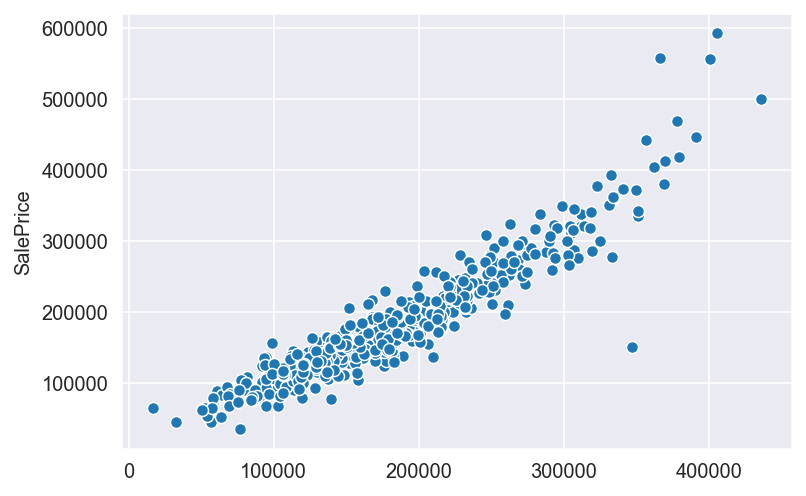

In [53]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_test,y_test)

In [54]:
lasso_model=lasso_model.fit(X,y)

In [55]:
cvs=cross_val_score(lasso_model,X,y,cv=10)
cvs.mean()

0.8565070544927872

In [56]:
lasso_model.intercept_

182010.67644969508

In [57]:
predictions_test=lasso_model.predict(test_sc)

In [58]:
predictions_test.mean()

178920.49929837618

In [59]:
submit=pd.DataFrame()

In [60]:
submit['Id']=test['Id']
submit['SalePrice']=predictions_test
submit=submit.set_index('Id')
submit.to_csv('submit_l1.csv')

In [61]:
submit.describe()

,SalePrice
count,879.000000
mean,178920.499298
std,67023.104422
min,17613.969746
25%,130112.430125
50%,165279.818810
75%,218863.650151
max,436525.470384


In [62]:
submit.shape

(879, 1)

In [63]:
lasso_model.coef_.shape

(169,)

In [64]:
test.shape

(879, 169)

### Using the coefficients of the lasso_model, we find the features that were used in the model and extract them to reduce the complexity of the model, and export for the next iteration

In [65]:
new_columns=test.columns[[(item>0)for column,item in zip(test.columns,lasso_model.coef_)]]

In [66]:
new_columns

Index(['Lot Area', 'Overall Qual', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC', '1st Flr SF',
       'Gr Liv Area', 'Kitchen Qual', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Area', 'Land Contour_HLS',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'Exterior 1st_BrkFace', 'Sale Type_New', 'bath_agg'],
      dtype='object')

In [67]:
new_columns=list(new_columns)

In [68]:
new_columns.append('Id')

In [69]:
len(new_columns)

26

In [70]:
train2=pd.DataFrame(train[new_columns])

In [71]:
test2=pd.DataFrame(test[new_columns])

In [72]:
train2['SalePrice']=train['SalePrice']

In [73]:
train2.to_csv('datasets/train_lassoed.csv')

In [74]:
test2.to_csv('datasets/test_lassoed.csv')

In [75]:
train2.shape

(2041, 27)

In [76]:
#train['SalePrice']

In [77]:
#get the polynomial features
target = 'SalePrice'
nc = [x for x in train2.columns if x != target]

X_train,X_test,y_train,y_test=train_test_split(train2[nc],train2[target])

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test= ss.transform(X_test)
#test2=test2.drop('SalePrice',axis=1)
test2_sc=ss.transform(test2)
X=ss.transform(train2[nc])



pf = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
X_train_poly=pf.fit_transform(X_train)
X_test_poly=pf.fit_transform(X_test)
X_train_poly.shape
X_poly=pf.fit_transform(X)
test2_sc_poly=pf.fit_transform(test2_sc)
test_poly_cols=pf.get_feature_names(test2.columns)

In [78]:
X_train.shape

(1530, 26)

In [79]:
X_train_poly.shape

(1530, 351)

In [80]:
test2_sc_poly.shape

(879, 351)

In [103]:
l_alphas = np.logspace(2.5, 6, 100)
lasso_model = Lasso(alpha=9000,max_iter=10000000)
#lasso_model = LassoCV(alphas=l_alphas, cv=10,max_iter=100000, fit_intercept=True)
lasso_model = lasso_model.fit(X_train_poly, y_train)

In [104]:
cross_val_score(lasso_model,X_train_poly,y_train,cv=5).mean()

0.8108306357965098

In [105]:
lasso_model.alpha

9000

In [106]:
len([column for column,item in zip(test_poly_cols,lasso_model.coef_) if (item>0)])

25

In [107]:
test_predictions=lasso_model.predict(X_test_poly)

0.8508500072473362

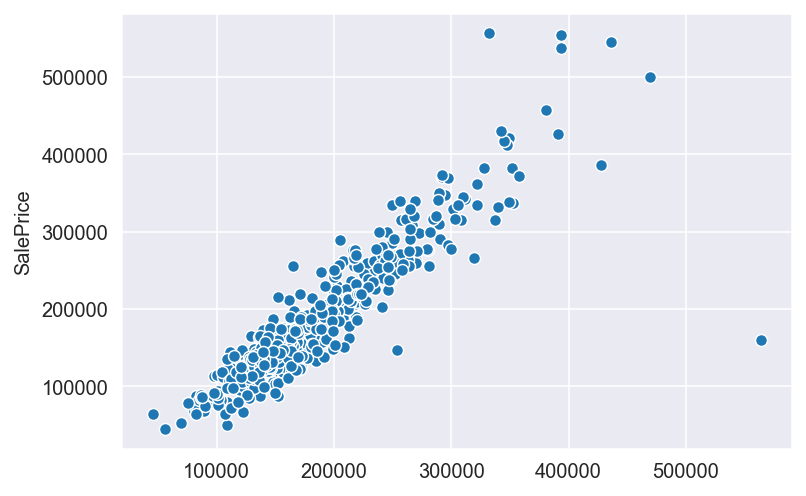

In [108]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_train_poly,y_train)

0.8127906072873818

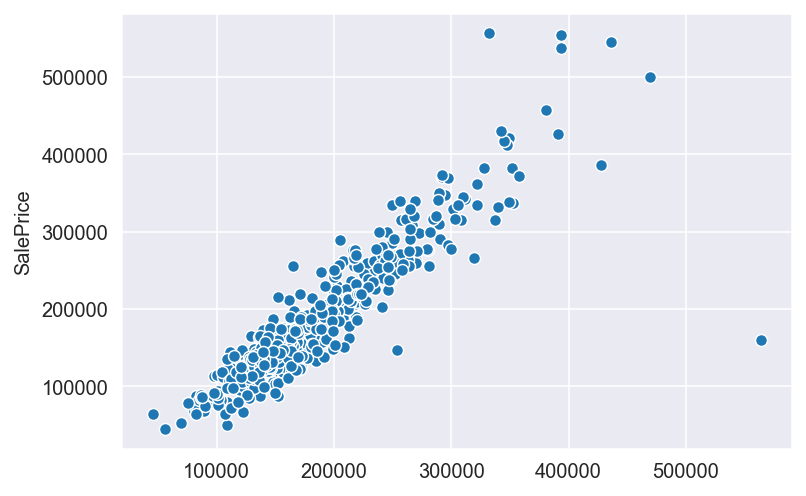

In [109]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_test_poly,y_test)

In [110]:
lasso_model.intercept_

174751.6036444298

In [111]:
pd.set_option('display.max_columns', 100)

In [112]:
predictions_test=lasso_model.predict(test2_sc_poly)

In [113]:
submit['Id']=list(test2['Id'])
submit['SalePrice']=predictions_test
submit=submit.set_index('Id')
submit.to_csv('submissions/dllagg.csv')

In [114]:
submit.head()

,SalePrice
Id,
2658,154439.194870
2718,178486.473100
2414,200421.363705
1989,128051.792225
625,178613.417244


In [115]:
len(lasso_model.coef_)

351

In [116]:
new_columns=[column for column,item in zip(test_poly_cols,lasso_model.coef_) if (item>0)]

In [117]:
len(new_columns)

25

In [118]:
new_train=pd.DataFrame(X_poly,columns=test_poly_cols)
new_train=new_train[new_columns]
new_train['SalePrice']=train['SalePrice']

In [119]:
new_test=pd.DataFrame(test2_sc_poly,columns=test_poly_cols)
new_test=new_test[new_columns]
new_test['SalePrice']=np.zeros(shape=(879,))


In [120]:
new_test.to_csv('datasets/lltest.csv')
new_train.to_csv('datasets/lltest.csv')